from PIL import UnidentifiedImageError, Image
import os

def remove_corrupted_images(root_dir):
    for root, _, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
            except (UnidentifiedImageError, OSError):
                print(f"Removing corrupted file: {file_path}")
                os.remove(file_path)

remove_corrupted_images("PetImages")


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


val_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
dataset = datasets.ImageFolder(root='PetImages', transform=train_transforms)

In [2]:
from torch.utils.data import Subset, DataLoader

subset_size_per_class = 2500  
class_indices = {cls: [] for cls in range(len(dataset.classes))}

for idx, (_, label) in enumerate(dataset):
    if len(class_indices[label]) < subset_size_per_class:
        class_indices[label].append(idx)
    if all(len(lst) >= subset_size_per_class for lst in class_indices.values()):
        break

subset_indices = class_indices[0] + class_indices[1]
small_dataset = Subset(dataset, subset_indices)
train_size = int(0.8 * len(small_dataset))
val_size = len(small_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    small_dataset, [train_size, val_size]
)

train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

print(f"Subset size: {len(small_dataset)} images")
print(f"Train size: {len(train_dataset)} | Val size: {len(val_dataset)}")


Subset size: 5000 images
Train size: 4000 | Val size: 1000


In [3]:
class_names=dataset.classes
print(class_names)
print(class_names[0],":",len(class_indices[0]),"|",class_names[1],":",len(class_indices[1]))

['Cat', 'Dog']
Cat : 2500 | Dog : 2500


In [4]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128*8*8, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = CNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=8192, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_fea

In [5]:
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
print(device)

cpu


In [6]:
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")
print(f"Number of train batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
test_batch = next(iter(train_loader), None)
if test_batch is None:
    print("train_loader is empty!")
else:
    images, labels = test_batch
    print(f"Sample batch shape: {images.shape}, {labels.shape}")

Train dataset size: 4000
Validation dataset size: 1000
Number of train batches: 32
Number of validation batches: 8

Validation dataset size: 1000
Number of train batches: 32
Number of validation batches: 8
Sample batch shape: torch.Size([128, 3, 64, 64]), torch.Size([128])
Sample batch shape: torch.Size([128, 3, 64, 64]), torch.Size([128])


In [7]:
from collections import Counter
labels = [dataset.targets[i] for i in subset_indices]
print(Counter(labels))


Counter({0: 2500, 1: 2500})


In [8]:
import torch

epochs = 20
train_accuracy_list = []
val_accuracy_list = []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1).float()
        optimizer.zero_grad(set_to_none=True)  
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs > 0.5)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_accuracy = 100 * correct / total
    train_accuracy_list.append(train_accuracy)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.inference_mode():   
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1).float()
            outputs = model(images)
            predicted = (outputs > 0.5)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%", flush=True)

Epoch [1/20], Loss: 0.6875, Train Acc: 55.27%, Val Acc: 51.10%
Epoch [2/20], Loss: 0.6612, Train Acc: 61.70%, Val Acc: 66.80%
Epoch [2/20], Loss: 0.6612, Train Acc: 61.70%, Val Acc: 66.80%
Epoch [3/20], Loss: 0.6385, Train Acc: 64.85%, Val Acc: 67.50%
Epoch [3/20], Loss: 0.6385, Train Acc: 64.85%, Val Acc: 67.50%
Epoch [4/20], Loss: 0.6203, Train Acc: 66.35%, Val Acc: 68.30%
Epoch [4/20], Loss: 0.6203, Train Acc: 66.35%, Val Acc: 68.30%
Epoch [5/20], Loss: 0.6037, Train Acc: 69.28%, Val Acc: 69.30%
Epoch [5/20], Loss: 0.6037, Train Acc: 69.28%, Val Acc: 69.30%
Epoch [6/20], Loss: 0.5897, Train Acc: 69.72%, Val Acc: 68.20%
Epoch [6/20], Loss: 0.5897, Train Acc: 69.72%, Val Acc: 68.20%
Epoch [7/20], Loss: 0.5758, Train Acc: 70.55%, Val Acc: 68.70%
Epoch [7/20], Loss: 0.5758, Train Acc: 70.55%, Val Acc: 68.70%
Epoch [8/20], Loss: 0.5746, Train Acc: 70.70%, Val Acc: 70.00%
Epoch [8/20], Loss: 0.5746, Train Acc: 70.70%, Val Acc: 70.00%
Epoch [9/20], Loss: 0.5658, Train Acc: 71.67%, Val Acc:

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [36]:
print(train_accuracy_list)
print(val_accuracy_list)

[58.15, 66.025, 67.95, 69.7, 70.0, 71.3, 72.8, 73.175, 73.175, 74.15, 74.625, 74.675, 76.05, 76.1, 77.1, 77.75, 77.425, 78.4, 78.6, 79.95]
[52.3, 63.5, 64.9, 66.2, 66.5, 66.7, 66.8, 67.2, 68.9, 69.1, 69.2, 69.4, 70.2, 69.6, 70.6, 70.8, 70.7, 72.2, 71.4, 72.9]


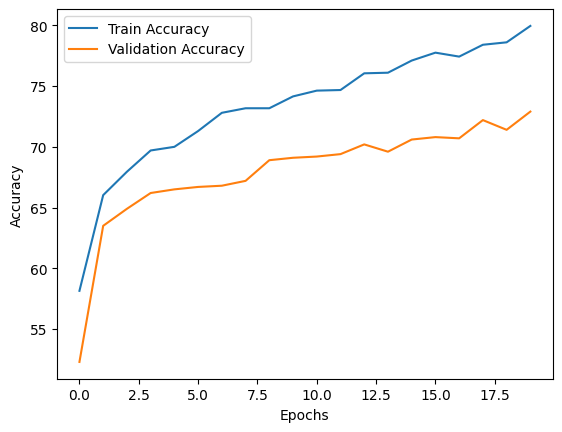

In [37]:
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt

plt.plot(train_accuracy_list,label='Train Accuracy')
plt.plot(val_accuracy_list,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [38]:
print(dataset.classes)

['Cat', 'Dog']


In [46]:
img = "C:\\Users\\puppy\\Documents\\AI & ML\\CAPTCHA_cats_and_dogs\\PetImages\\Dog\\37.jpg"
from PIL import Image
image = Image.open(img).convert("RGB")
image_tensor = val_transforms(image).unsqueeze(0).to(device)
with torch.no_grad():
    output = model(image_tensor)
    print("Raw model output:", output.item())
    pred = (output > 0.5).item()
    print("Predicted class:", "Dog" if pred else "Cat")

Raw model output: 0.9058315753936768
Predicted class: Dog


In [40]:
torch.save(model.state_dict(), "model.pth")